In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from astropy.table import Table, vstack, Column
import os
import pdb
import warnings
import sys
import pandas as pd
from pandas import DataFrame as df

working_dir = '/Users/Gianna/Documents/GitHub/SIP2019/'

sys.path

['',
 '/Users/Gianna/Documents/GitHub/SIP2019/Giovanni',
 '/Users/Gianna/anaconda3/lib/python37.zip',
 '/Users/Gianna/anaconda3/lib/python3.7',
 '/Users/Gianna/anaconda3/lib/python3.7/lib-dynload',
 '/Users/Gianna/anaconda3/lib/python3.7/site-packages',
 '/Users/Gianna/anaconda3/lib/python3.7/site-packages/aeosa',
 '/Users/Gianna/anaconda3/lib/python3.7/site-packages/IPython/extensions',
 '/Users/Gianna/.ipython']

In [2]:
path1 = './../spectra/'
path2 = './../catalogs/'

bigFile = Table.read('bigfile-Copy1.fits')

vdgcfiles = []
vugcfiles = []
vccfiles = []
vccfilesfits = []
allnames = list(bigFile['SPEC1DNAME'])
vdgcfilesall = []
for i in range(len(allnames)):
    vdgcfilesall.append(allnames[i][:-3])
for filename in os.listdir(path1):
    if ((filename in allnames)|(filename in vdgcfilesall)):
        if((filename.endswith('.fits')) & ('spec' in filename)):
           vdgcfiles.append(filename)
        if ((filename.endswith('.gz')) & ('spec' in filename)):
           vugcfiles.append(filename)
    elif(filename.startswith('VCC')):
        vccfilesfits.append(filename)
        vccfiles.append(filename[:-5])
vdgcfilesgz = []
for name in vdgcfiles:
    vdgcfilesgz.append(name +'.gz')
restFrame = []
velocity = []
VUGC = []

for string in vugcfiles:
    file = fits.open (path1 + string)
    wavelength = file[1].data['LAMBDA']
    for otherFile in bigFile:
        if (string == otherFile['SPEC1DNAME']):
            velocityVal = otherFile ['VOBS']
            VUGC.append(otherFile)
            
            velocity.append(velocityVal)
            a = wavelength * ((1)/(1+(velocityVal/(3e+5))))
            restFrame.append(a)
            
restFrame  

[array([[4702.636, 4703.243, 4703.849, ..., 7273.251, 7273.894, 7274.537]],
       dtype=float32),
 array([[4537.4585, 4538.332 , 4539.205 , ..., 7164.832 , 7165.537 ,
         7166.2427]], dtype=float32),
 array([[4400.4136, 4400.991 , 4401.568 , ..., 6973.8945, 6974.54  ,
         6975.1855]], dtype=float32),
 array([[4663.761 , 4664.343 , 4664.925 , ..., 7230.737 , 7231.3823,
         7232.028 ]], dtype=float32),
 array([[4458.0596, 4458.641 , 4459.2227, ..., 7032.499 , 7033.1436,
         7033.7876]], dtype=float32),
 array([[4324.8105, 4325.3745, 4325.939 , ..., 6891.3047, 6891.9497,
         6892.594 ]], dtype=float32),
 array([[4327.507 , 4328.066 , 4328.625 , ..., 6883.6665, 6884.308 ,
         6884.95  ]], dtype=float32),
 array([[4638.225 , 4638.822 , 4639.4175, ..., 7214.5747, 7215.2188,
         7215.8623]], dtype=float32),
 array([[5035.828 , 5036.4395, 5037.0513, ..., 7619.861 , 7620.5073,
         7621.1533]], dtype=float32),
 array([[5054.631 , 5055.2407, 5055.8516, ...

In [3]:
sys.path.append(working_dir + 'lib')

from py_specrebin import rebinspec

allfluxes = []
alllambdas = []
allvariances = []

#I believe this should be a for loop
flux = file[1].data['SPEC'] #Need to change the [1] (only looking at one file, have to look at all of them)
wavelength = file[1].data['LAMBDA']
invar = file[1].data['IVAR']
allfluxes.append(flux)
alllambdas.append(wavelength)
allvariances.append(invar)

correct = np.arange(4000,8750.9,0.9)

i = 0

newfluxUDG,newvarUDG = rebinspec(wavelength[i], flux[i], correct, ivar = invar[i])

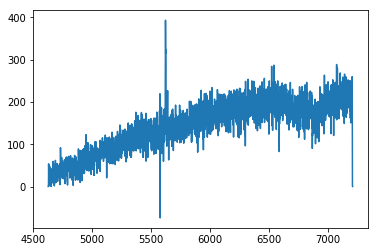

In [4]:
plt.plot(correct,newfluxUDG)

In [5]:
vobsDE = []
bigFile.sort('SPEC1DNAME')
for file in vdgcfilesgz:
    vobsDE.append(float((bigFile[bigFile['SPEC1DNAME'] == file])['VOBS']))
vobsUDG=[]
for file in vugcfiles:
    vobsUDG.append(float((bigFile[bigFile['SPEC1DNAME'] == file])['VOBS']))
vobsVCC=[]
for file in vccfiles:
    vobsVCC.append(float((bigFile[bigFile['VCC']== 'VCC1488'])['VOBS']))
    
# put in for loop

In [6]:
def coaddition(files, velocities):
    allfluxes = []
    alllambdas = []
    allvariances = []
    for i in range(len(files)):
        f = fits.open(path1 + files[i])
        
        try:
            specB = f['Bxspf-' + 'B'] # Look through 'Bxspf-' for blue and red before looking through 'Horne-'
            specR = f['Bxspf-' + 'R']
        except:
            specB = f['Horne-' + 'B']
            specR = f['Horne-' + 'R']
            
        nuewaveB= specB.data['LAMBDA']
        antiguoB= nuewaveB/(1+((velocities[i]/300000))) #Doppler shift correction (300,000 = speed of light)
        nuewaveR= specR.data['LAMBDA']
        antiguoR= nuewaveR/(1+((velocities[i]/300000)))
        
        alllambdas.append(np.append(antiguoB,antiguoR)) # Blue lambdas to red
        allfluxes.append(np.append(specB.data['SPEC'],specR.data['SPEC'])) # Blue spectras to red
        allvariances.append(np.append(specB.data['IVAR'],specR.data['IVAR'])) # Blue variances to red
        f.close()
    return alllambdas, allfluxes, allvariances
#  Figure out vobs stuff (vobsDE, vobsUDG, vobsVCC) - check out table on other notebook

In [7]:
RBlambdaDE, RBfluxDE, RBinvarDE = coaddition(vdgcfiles, vobsDE)
RBlambdaUDG, RBfluxUDG, RBinvarUDG = coaddition(vugcfiles,vobsUDG)
RBlambdaVCC, RBfluxVCC, RBinvarVCC = coaddition (vccfilesfits, vobsVCC)
testlambdaDE = RBlambdaDE[:10]
testfluxDE = RBfluxDE[:10]                       #get first 10 files so I can work with the data
testvarianceDE = RBinvarDE[:10]

testlambdaUDG= RBlambdaUDG[:10]                  #first ten plots for UDG
testfluxUDG = RBfluxUDG [:10]
testvarianceUDG = RBinvarUDG [:10]

testlambdaVCC = RBlambdaVCC [:10]                #first ten plots for VCC
testfluxVCC = RBfluxVCC [:10]
testvarianceVCC = RBinvarVCC [:10]

In [11]:
fluxesDE = np.zeros((len(testlambdaDE), len(correct)))
varsDE = np.zeros((len(testlambdaDE), len(correct)))

for i in range(len(testlambdaDE)):
    newfluxDE, newvarDE = np.nan_to_num(rebinspec(testlambdaDE[i], testfluxDE[i], correct, ivar = testvarianceDE[i]))
    fluxesDE[i][:] = newfluxDE
    varsDE[i][:] = newvarDE
    
fluxesUDG = np.zeros((len(testlambdaUDG), len(correct)))
varsUDG = np.zeros((len(testlambdaUDG), len(correct)))

for i in range(len(testlambdaUDG)):
    newfluxUDG, newvarUDG = np.nan_to_num(rebinspec(testlambdaUDG[i], testfluxUDG[i], correct, ivar = testvarianceUDG[i]))
    fluxesUDG[i][:] = newfluxUDG
    varsUDG[i][:] = newvarUDG

fluxesVCC = np.zeros((len(testlambdaVCC), len(correct)))
varsVCC = np.zeros((len(testlambdaVCC), len(correct)))

for i in range(len(testlambdaVCC)):
    newfluxVCC, newvarVCC = np.nan_to_num(rebinspec(testlambdaVCC[i], testfluxVCC[i], correct, ivar = testvarianceVCC[i]))
    fluxesVCC[i][:] = newfluxVCC
    varsVCC[i][:] = newvarVCC
    

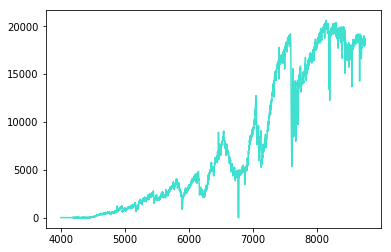

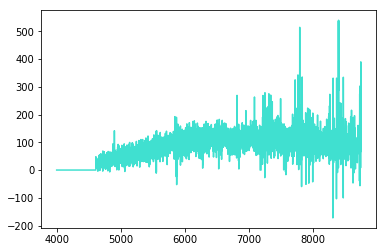

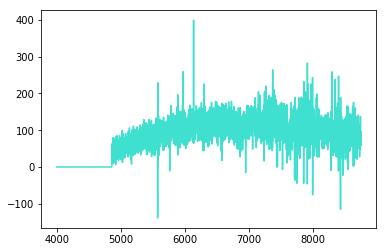

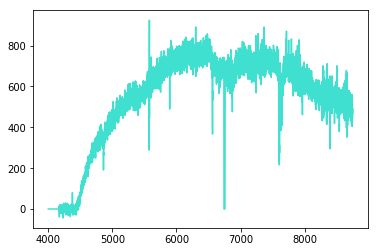

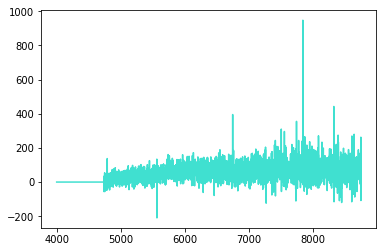

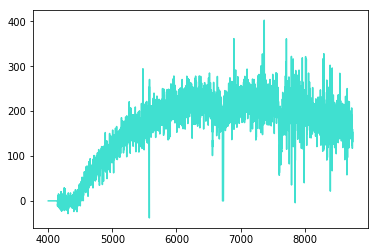

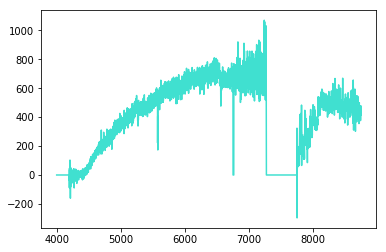

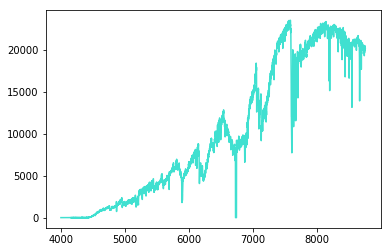

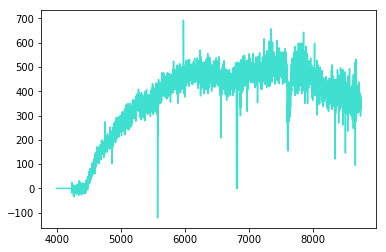

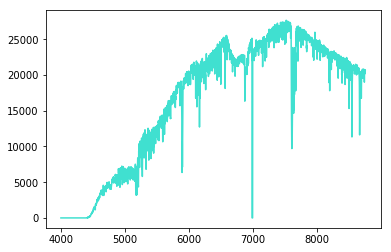

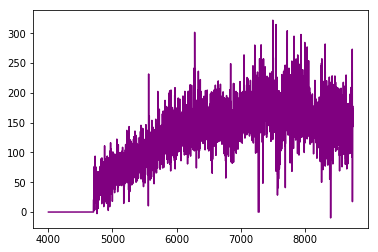

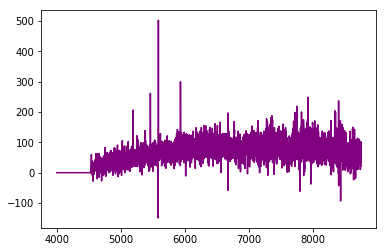

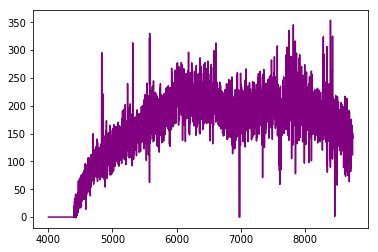

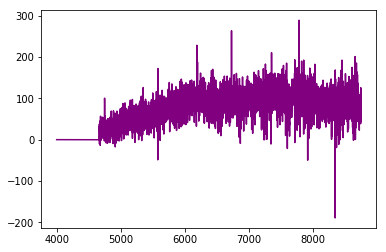

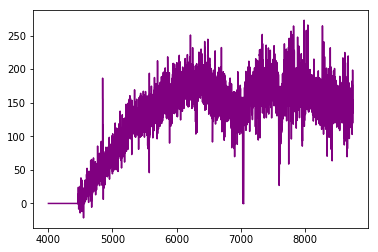

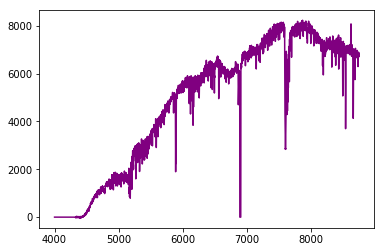

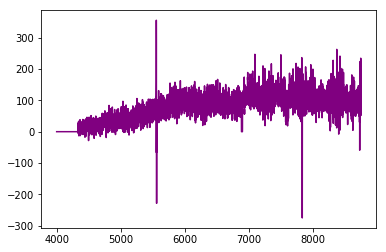

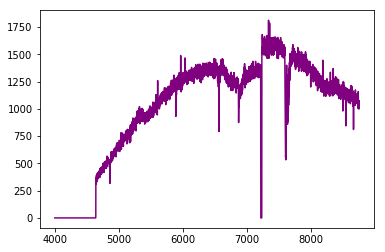

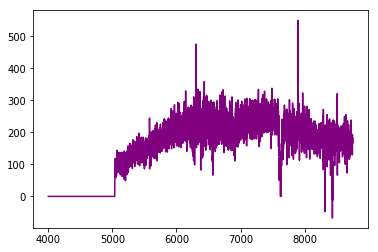

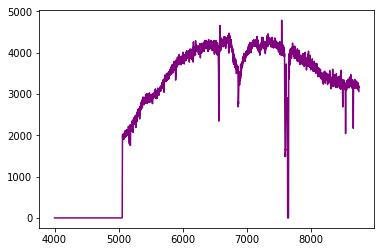

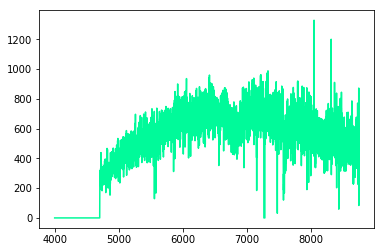

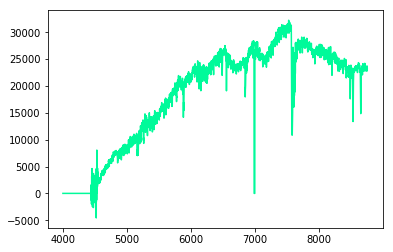

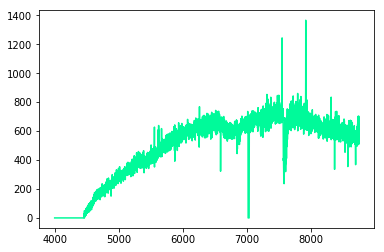

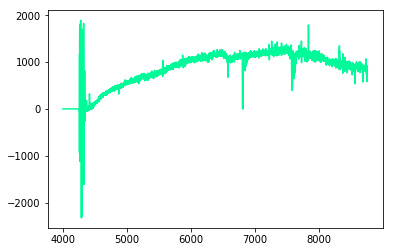

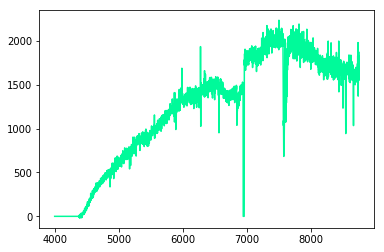

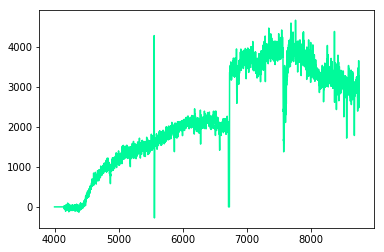

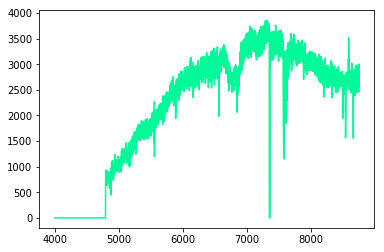

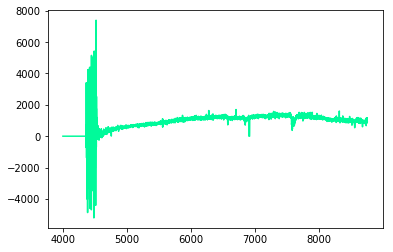

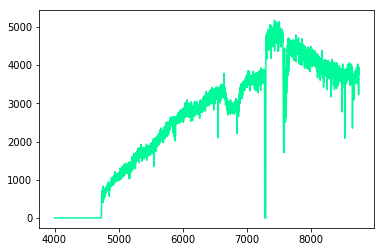

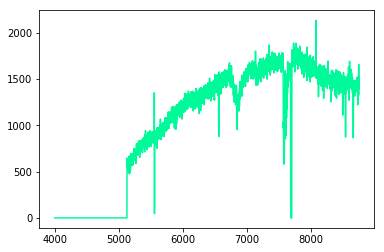

In [9]:
for i in range(len(fluxesDE)):
    plt.plot(correct,fluxesDE[i],color='turquoise')
    plt.show()

for i in range(len(fluxesUDG)):
    plt.plot(correct,fluxesUDG[i], color = 'purple')
    plt.show()
    
for i in range(len(fluxesVCC)):
    plt.plot(correct,fluxesVCC[i], color = 'mediumspringgreen')
    plt.show()
    

In [14]:
df = pd.DataFrame(flux)
for i in range(len(df.columns)):
    mean = df[i].mean()
    stdev = df[i].std() # Only looking at one table (go back to flux and fix the [1])
    minlim = mean - (3*stdev)
    maxlim = mean + (3*stdev)            #Figure out how to make values '0' if less than min and more than max

    
# If stdev, minlim, and maxlim printed, 'nan' shows up (that's definitely wrong)